# Distracted Driver detection


Here in the image data preprocessing part, I mainly referenced the method of ZFTurbo in the Kaggle kernel.

In [1]:
#import the modules
import os
import cv2
import glob
import gc
import sys
import numpy as np
import pickle
import time
from scipy import misc
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import log_loss
from keras import applications
from keras.applications.xception import Xception
from keras.callbacks import CSVLogger


from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Convolution2D,MaxPooling2D
from keras import optimizers
from keras import regularizers
from keras.initializers import TruncatedNormal


from keras.preprocessing.image import ImageDataGenerator

from keras import optimizers

Using TensorFlow backend.


Here are the functions for preprocessing the data.

In [2]:
#import images
def input_img(path,img_width,img_height,color_type=1):
    if color_type==1:
        img=cv2.imread(path,0) #input as grey-scale
    elif color_type==3:
        img=cv2.imread(path)
    
    resize=cv2.resize(img,(img_width,img_height))
    
    return resize

In [3]:
#import drivers' labels
def input_drivers():
    driver_dict={}
    file_path=os.path.join('driver_imgs_list.csv')
    
    f=open(file_path,'r')
    line=f.readline()
    while 1:
        line=f.readline()
        terms=line.strip().split(',')
        if len(terms)!=3:
            break
        else:
            driver_dict[terms[2]]=terms[0]
    f.close()
    return driver_dict

In [4]:
def load_train_data(img_width,img_height,color_type=1):
    X_train=[]
    y_train=[]
    driver_id=[]
    driver_info=input_drivers()
    start_time=time.time()
    
    for i in range(10):
        print('Loading training images from c{}...'.format(i))
        paths=os.path.join('train','c'+str(i),'*.jpg')
        files=glob.glob(paths)
        for file in files:
            
            file_name=os.path.basename(file)
            img=input_img(file,img_width,img_height,color_type)
            X_train.append(img)
            y_train.append(i)
            
            driver_id.append(driver_info[file_name])
            
    individual_driver=list(set(driver_id))
    end_time=time.time()
    print('Total loading time: {}'.format(round((end_time-start_time),2)))
    
    return X_train,y_train,driver_id,individual_driver
        

In [5]:
def load_test_data(img_width,img_height,color_type=1):
    X_test=[]
    X_test_id=[]
    start_time=time.time()
    

    print('Loading testing images...')
    paths=os.path.join('test','*.jpg')
    files=glob.glob(paths)

    for file in files:
        file_name=os.path.basename(file)
        img=input_img(file,img_width,img_height,color_type)
        X_test.append(img)
        X_test_id.append(file_name)
            
    
    return X_test,X_test_id

In [6]:
def preprocess_data(X):    
    
    return (np.array(X)/255.-0.5)*2.

In [7]:
def one_hot_code(y):
    return np.eye(10)[y]

In [8]:
def import_selected_drivers(X,y,driver_id,driver_list):
    #Save the pictures for each driver
    
    features=[]
    labels=[]
    
    for i in range(len(driver_id)):
        if driver_id[i] in driver_list:
            features.append(X[i]) 
            labels.append(y[i])    

    
    return features,labels
    

# Finetune-Xception

In [20]:
def Xception_fine_tune_model(img_width,img_height,color_type):
    
    base_model=Xception(weights='imagenet',include_top=False,pooling='avg',input_shape=(img_width,img_height,color_type))
    print('Xception model loaded...')
    top_model= Sequential()
    top_model.add(Dense(64,kernel_initializer='he_normal',input_shape=(base_model.output_shape[1],)))
    top_model.add(BatchNormalization())
    top_model.add(Activation('relu'))
    top_model.add(Dropout(0.5))
#    top_model.add(Dense(64,kernel_initializer='he_normal'))
#    top_model.add(BatchNormalization())
#    top_model.add(Activation('relu'))
#    top_model.add(Dropout(0.5))

    top_model.add(Dense(10))
    top_model.add(BatchNormalization())
    top_model.add(Activation('softmax'))
    
    
    model=Model(inputs=base_model.input, outputs=top_model(base_model.output))

    print('Layers in base_model: ',len(base_model.layers))
    print('Layers in top_model: ',len(top_model.layers))  
    print('Layers in model: ',len(model.layers))
    print('')
    
    for layer in model.layers[-35:]:
        layer.trainable=True
    for layer in model.layers[:-35]:
        layer.trainable=False
        
    model.summary()            
    return model

In [21]:
img_width=299
img_height=299
color_type=3
model=Xception_fine_tune_model(img_width,img_height,color_type)

Xception model loaded...
Layers in base_model:  133
Layers in top_model:  7
Layers in model:  134

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 149, 149, 32)  864         input_7[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 149, 149, 32)  128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 149, 149, 32)  0           block1_conv1_bn[0][0]     

In [10]:
def random_crop_image(image):
    height,width=image.shape[:2]
    random_array=np.random.random(size=4)
    w=int(width*random_array[0]*0.3)
    h=int((height*0.5)*(1+random_array[1]*0.5))
    x=int(random_array[2]*(width-w))
    y=int(random_array[3]*(height-h))
    
    image_crop=image[y:y+h,w:,0:3]
    image_crop=cv2.resize(image_crop,(height,width))
    #image_crop=misc.imresize(image_crop,image.shape)
 
    return image_crop

In [11]:
'''
def Single_run_finetune_Xception(run_content):
    img_width=299
    img_height=299
    color_type=3
    epochs=25
    batch_size=1024
    
    
    print('Loading training images...')
    X_train,y_train,driver_id,driver_set=load_train_data(img_width,img_height,color_type)

#    test_data,test_id=load_test_data(img_width,img_height,color_type)
#    test_data=normalize_data(test_data)
    
    print('')
    print('Generating training and validation data by drivers...')
    
    driver_train_list=['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024',
                     'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049',
                     'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072',
                     'p075']
    
    driver_val_list=['p081']
    
    train_data,train_target=import_selected_drivers(X_train,y_train,driver_id,driver_train_list)
    val_data,val_target=import_selected_drivers(X_train,y_train,driver_id,driver_val_list)
    print('Training and validation data generated...')
    
    #release the X_train y_train data
    del X_train
    del y_train
    gc.collect()
    
    
    train_data=np.array(train_data,dtype=np.float32)
    train_data /=255.
    train_data -=0.5
    train_data *=2.
    
    
    val_data=np.array(val_data,dtype=np.float32)
    val_data /=255.
    val_data -=0.5
    val_data *=2.
        
    train_target=one_hot_code(train_target)
    val_target=one_hot_code(val_target)


    if color_type==1:
        train_data=train_data.reshape(train_data.shape[0],img_width,img_height,color_type)
        val_data=val_data.reshape(val_data.shape[0],img_width,img_height,color_type)
#   test_data=test_data.reshape(test_data.shape[0],img_width,img_height,color_type)
#    train_data=train_data.astype('float32')
#    val_data=val_data.astype('float32')
    
    print('')
    print('The data dimension as follows: ')
    print('Train features shape: ',train_data.shape)
    print('Train labels shape: ',train_target.shape)
    print('Val features shape: ',val_data.shape)
    print('Val labels shape: ',val_target.shape)
    
#    print('Saving preprocessed data...')
#    np.save('train_data.npy',train_data)
#    np.save('train_target.npy',train_target)
#    np.save('val_data.npy',val_data)
#    np.save('val_target.npy',val_target)
#    print('Preprocessed data saved...')
#    print('Test features shape: ',test_data.shape)
#    print('Test labels shape: ',test_target.shape)
    print('')
    
    model=Xception_fine_tune_model(img_width,img_height,color_type)
    
    Adam=optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    
    model.summary()
    
    for e in range(epochs):
        print('Epoch', e)
        batches = 0
        
        datagen1=ImageDataGenerator()
        
        datagen2=ImageDataGenerator(rotation_range=40,
                width_shift_range=0.5,
                height_shift_range=0.5,
                shear_range=0.5,
                zoom_range=0.5,
                horizontal_flip=True)
        
        print('Training with orignal data...')
        for x_batch, y_batch in datagen1.flow(train_data, train_target, batch_size=batch_size):
            model.fit(x_batch, y_batch,validation_data=(val_data,val_target))
            batches += 1
            if batches >= len(train_data) // batch_size+1:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        
        batches=0
        print('Training with augemented data...')                
        for x_batch, y_batch in datagen2.flow(train_data, train_target, batch_size=batch_size):
            model.fit(x_batch, y_batch,validation_data=(val_data,val_target))
            batches += 1
            if batches >= len(train_data) //batch_size+1:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        
        if e%5==0:
            model.save_weights('weights_model_xception_'+str(run_content)+'.h5')
            print('weights saved for this epoch...')
                
    prediction_valid=model.predict(val_data,batch_size=64,verbose=1)
    score=log_loss(val_target,prediction_valid)
    print('Score log_loss: ', score)
    
    #model.save_weights('weights_model_xception_'+str(run_content)+'.h5')
'''

"\ndef Single_run_finetune_Xception(run_content):\n    img_width=299\n    img_height=299\n    color_type=3\n    epochs=25\n    batch_size=1024\n    \n    \n    print('Loading training images...')\n    X_train,y_train,driver_id,driver_set=load_train_data(img_width,img_height,color_type)\n\n#    test_data,test_id=load_test_data(img_width,img_height,color_type)\n#    test_data=normalize_data(test_data)\n    \n    print('')\n    print('Generating training and validation data by drivers...')\n    \n    driver_train_list=['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024',\n                     'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049',\n                     'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072',\n                     'p075']\n    \n    driver_val_list=['p081']\n    \n    train_data,train_target=import_selected_drivers(X_train,y_train,driver_id,driver_train_list)\n    val_data,val_target=import_selected_drivers(X_train,y_train,driver_

In [15]:
def Single_run_finetune_Xception_CV(run_content):
    img_width=299
    img_height=299
    color_type=3
    epochs=4
    batch_size=128
    n_kfold=5
    
    print('Loading training images...')

    X_train,y_train,driver_id,driver_set=load_train_data(img_width,img_height,color_type)

#    test_data,test_id=load_test_data(img_width,img_height,color_type)
#    test_data=normalize_data(test_data)    

    driver_list=np.array(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024',
                     'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049',
                     'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072',
                     'p075','p081'])



    kf=KFold(n_kfold)
    num_fold=1
    val_losses=[]

    
    for index_train, index_valid in kf.split(driver_list):   

        print('')
        print('KFold with {} in total {} Folds'.format(num_fold,n_kfold))
              

        print('Generating training and validation data by drivers, the validation driver is {}'.format(driver_list[index_valid]))
        train_data,train_target=import_selected_drivers(X_train,y_train,driver_id,driver_list[index_train])
        val_data,val_target=import_selected_drivers(X_train,y_train,driver_id,driver_list[index_valid])

            
        train_data=np.array(train_data,dtype=np.float32)
        train_data /=255.
        train_data -=0.5
        train_data *=2.
    
    
        val_data=np.array(val_data,dtype=np.float32)
        val_data /=255.
        val_data -=0.5
        val_data *=2.
        
        train_target=one_hot_code(train_target)
        val_target=one_hot_code(val_target)
            

         
        model=Xception_fine_tune_model(img_width,img_height,color_type)
    
        Adam=optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    
        #model.summary()
        csv_logger=CSVLogger('model_train_history.csv')
        
        for e in range(epochs):
            print('Epoch {} of total epochs {}'.format(e,epochs))
                
            datagen1=ImageDataGenerator()
        
            datagen2=ImageDataGenerator(rotation_range=40,
                width_shift_range=0.5,
                height_shift_range=0.5,
                shear_range=0.5,
                zoom_range=0.5,
                horizontal_flip=True)
            
            datagen3=ImageDataGenerator(rotation_range=20,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.1,
                zoom_range=0.1,
                preprocessing_function=random_crop_image,
                fill_mode='reflect',
                horizontal_flip=True)

            batches=0
            
            print('')
            print('Training with orignal data...')

            
            for x_batch, y_batch in datagen1.flow(train_data, train_target, batch_size=batch_size):
                model.fit(x_batch, y_batch,callbacks=[csv_logger],verbose=0)

#                score_train=model.evaluate(x_batch, y_batch,verbose=0)
#                score_val=model.evaluate(val_data, val_target,verbose=0)
#                print('\r','Batch: {}, train_loss: {:.5}, train_accuracy: {:.5}, val_loss {:.5}, val_accuracy: {:.5}'.format(batches,score_train[0],score_train[1],score_val[0],score_val[1]),end='')
                
                batches += 1
                if batches >= len(train_data) // batch_size+1:
                    # we need to break the loop by hand because
                    # the generator loops indefinitely
                    break
        
            batches=0
            print('')
            print('Training with augemented data version 1...') 

            for x_batch, y_batch in datagen2.flow(train_data, train_target, batch_size=batch_size):
                model.fit(x_batch, y_batch,callbacks=[csv_logger],verbose=0)

                
#                score_train=model.evaluate(x_batch, y_batch,verbose=0)
#                score_val=model.evaluate(val_data, val_target,verbose=0)
#                print('\r','Batch: {}, train_loss: {:.5}, train_accuracy: {:.5}, val_loss {:.5}, val_accuracy: {:.5}'.format(batches,score_train[0],score_train[1],score_val[0],score_val[1]),end='')
                
                
                batches += 1
                if batches >= len(train_data) //batch_size+1:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                    break
            
            batches=0
            print('')
            print('Training with augemented data version 2...') 

            for x_batch, y_batch in datagen3.flow(train_data, train_target, batch_size=batch_size):
                model.fit(x_batch, y_batch,callbacks=[csv_logger],verbose=0)

                
#                score_train=model.evaluate(x_batch, y_batch,verbose=0)
#                score_val=model.evaluate(val_data, val_target,verbose=0)
#                print('\r','Batch: {}, train_loss: {:.5}, train_accuracy: {:.5}, val_loss {:.5}, val_accuracy: {:.5}'.format(batches,score_train[0],score_train[1],score_val[0],score_val[1]),end='')
                
                
                batches += 1
                if batches >= len(train_data) //batch_size+1:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                    break

        prediction_valid=model.predict(val_data,batch_size=64,verbose=1)
        score=log_loss(val_target,prediction_valid)
        print('Score log_loss: ', score)
        val_losses.append(score)       

        model.save('model_'+str(num_fold)+'_xception_'+str(run_content)+'_total-epochs_'+str(epochs)+'_val_loss_'+str(round(score,4))+'.h5')
        print('model saved for kfold'.format())
        
        del model     
        num_fold+=1
    
    loss_log=open('loss_log_kfold.txt','w')
    val_losses_avg=sum(val_losses)/len(val_losses)
    loss_log.write('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')
    loss_log.write('CV average Val loss: '+str(round(val_losses_avg,4))+'\n')
    loss_log.write('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')
    loss_log.close()
    

    
    #model.save_weights('weights_model_xception_'+str(run_content)+'.h5')

In [16]:
Single_run_finetune_Xception_CV('34layers+fc')

Loading training images...
Loading training images from c0...
Loading training images from c1...
Loading training images from c2...
Loading training images from c3...
Loading training images from c4...
Loading training images from c5...
Loading training images from c6...
Loading training images from c7...
Loading training images from c8...
Loading training images from c9...
Total loading time: 389.77

KFold with 1 in total 5 Folds
Generating training and validation data by drivers, the validation driver is ['p002' 'p012' 'p014' 'p015' 'p016' 'p021']
Xception model loaded...
Epoch 0 of total epochs 4

Training with orignal data...

Training with augemented data version 1...

Training with augemented data version 2...
Epoch 1 of total epochs 4

Training with orignal data...

Training with augemented data version 1...

Training with augemented data version 2...
Epoch 2 of total epochs 4

Training with orignal data...

Training with augemented data version 1...

Training with augemented da

In [ ]:
## img_width=299
img_height=299
color_type=3
epochs=25
batch_size=1024
    
print('Loading training images...')
X_train,y_train,driver_id,driver_set=load_train_data(img_width,img_height,color_type)

#    test_data,test_id=load_test_data(img_width,img_height,color_type)
#    test_data=normalize_data(test_data)
    
print('')
print('Generating training and validation data by drivers...')
driver_train_list=['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024',
                     'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049',
                     'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072',
                     'p075']
    
driver_val_list=['p081']
    
train_data,train_target=import_selected_drivers(X_train,y_train,driver_id,driver_train_list)
val_data,val_target=import_selected_drivers(X_train,y_train,driver_id,driver_val_list)
print('Training and validation data generated...')
    
    #release the X_train y_train data
del X_train
del y_train
gc.collect()
    
    
train_data=np.array(train_data,dtype=np.float32)
train_data /=255.
train_data -=0.5
train_data *=2.
    
    
val_data=np.array(val_data,dtype=np.float32)
val_data /=255.
val_data -=0.5
val_data *=2.
        
train_target=one_hot_code(train_target)
val_target=one_hot_code(val_target)



model=Xception_fine_tune_model(img_width,img_height,color_type)
model.load_weights('weights_model_xception_17+fc.h5')

prediction_valid=model.predict(val_data,batch_size=64,verbose=1)
score=log_loss(val_target,prediction_valid)
print('Score log_loss: ', score)



In [74]:
def random_crop_image(image):
    height,width=image.shape[:2]
    random_array=np.random.random(size=4)
    w=int(width*random_array[0]*0.3)
    h=int((height*0.5)*(1+random_array[1]*0.5))
    x=int(random_array[2]*(width-w))
    y=int(random_array[3]*(height-h))
    
    image_crop=image[y:y+h,w:,0:3]
    image_crop=cv2.resize(image_crop,(height,width))
    #image_crop=misc.imresize(image_crop,image.shape)
 
    return image_crop

In [80]:
img_width=299
img_height=299
color_type=3
epochs=25
batch_size=128

model=Xception_fine_tune_model(img_width,img_height,color_type)
model.load_weights('weights_model_xception_17+fc.h5')
Adam=optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])



    

for e in range(epochs):
        print('Epoch', e)
        batches = 0
        
        datagen2=ImageDataGenerator(rotation_range=40,
                width_shift_range=0.5,
                height_shift_range=0.5,
                shear_range=0.5,
                zoom_range=0.5,
                preprocessing_function=random_crop_image,
                horizontal_flip=True)
        
        datagen3=ImageDataGenerator(rotation_range=10,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.1,
                zoom_range=0.1,
                preprocessing_function=random_crop_image,
                fill_mode='reflect',
                horizontal_flip=True)
        
#        print('Training with orignal data...')
#        for x_batch, y_batch in datagen1.flow(train_data, train_target, batch_size=batch_size):
#            model.fit(x_batch, y_batch,validation_data=(val_data,val_target))
#            batches += 1
#            if batches >= len(train_data) // batch_size+1:
#                # we need to break the loop by hand because
#                # the generator loops indefinitely
#                break
        
#        batches=0
        print('Training with augemented data...')                
        for x_batch, y_batch in datagen2.flow(train_data, train_target, batch_size=batch_size):
            model.fit(x_batch, y_batch,validation_data=(val_data,val_target),verbose=1)
            batches += 1
            if batches >= len(train_data) //batch_size+1:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        
        if e%5==0:
            model.save_weights('weights_model_xception_imagecrop.h5')
            print('weights saved for this epoch...')

Xception model loaded...
Layers in base_model:  133
Layers in top_model:  15
Layers in model:  134
Epoch 0
Training with augemented data...
Train on 128 samples, validate on 823 samples
Epoch 1/1


ResourceExhaustedError: OOM when allocating tensor with shape[32,19,19,728]
	 [[Node: block11_sepconv1_9/separable_conv2d/depthwise = DepthwiseConv2dNative[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/gpu:0"](block11_sepconv1_act_9/Relu, block11_sepconv1_9/depthwise_kernel/read)]]
	 [[Node: loss_10/mul/_23239 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_26812_loss_10/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'block11_sepconv1_9/separable_conv2d/depthwise', defined at:
  File "/opt/anaconda3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/opt/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/opt/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/opt/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/opt/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/opt/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-80-5ddb9f34e676>", line 7, in <module>
    model=Xception_fine_tune_model(img_width,img_height,color_type)
  File "<ipython-input-79-7a87313b695c>", line 3, in Xception_fine_tune_model
    base_model=Xception(weights='imagenet',include_top=False,pooling='avg',input_shape=(img_width,img_height,color_type))
  File "/opt/anaconda3/lib/python3.5/site-packages/keras/applications/xception.py", line 195, in Xception
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv1')(x)
  File "/opt/anaconda3/lib/python3.5/site-packages/keras/engine/topology.py", line 602, in __call__
    output = self.call(inputs, **kwargs)
  File "/opt/anaconda3/lib/python3.5/site-packages/keras/layers/convolutional.py", line 1220, in call
    padding=self.padding)
  File "/opt/anaconda3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 3238, in separable_conv2d
    rate=dilation_rate)
  File "/opt/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/nn_impl.py", line 490, in separable_conv2d
    op=op)
  File "/opt/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 338, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/opt/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/nn_impl.py", line 482, in op
    name="depthwise")
  File "/opt/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 714, in depthwise_conv2d_native
    name=name)
  File "/opt/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/opt/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/opt/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,19,19,728]
	 [[Node: block11_sepconv1_9/separable_conv2d/depthwise = DepthwiseConv2dNative[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/gpu:0"](block11_sepconv1_act_9/Relu, block11_sepconv1_9/depthwise_kernel/read)]]
	 [[Node: loss_10/mul/_23239 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_26812_loss_10/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


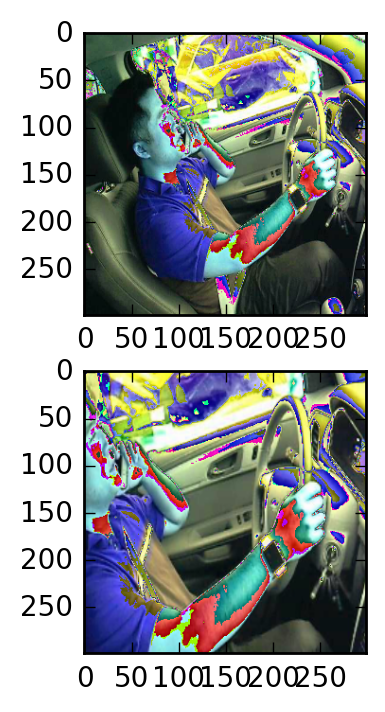

In [75]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

img_crop=random_crop_image(train_data[10200])
plt.axis('off')

plt.subplot(2,1,1)
plt.imshow(train_data[10200])
plt.subplot(2,1,2)
plt.imshow(img_crop)

In [14]:
loss_log1=open('loss_log_kfold.txt','w')
loss_log1.write('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')
loss_log1.write('CV average Val loss: '+str(0.23)+'\n')
loss_log1.write('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')
loss_log1.close()
    
    
